In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle
import os
from PIL import Image
from torchvision import transforms
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class test(nn.Module):
    def __init__(self):
        super(test, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding=1)  # Changed from 3 to 4 channels
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        # Dropout layers
        self.dropout25 = nn.Dropout(0.25)
        self.dropout50 = nn.Dropout(0.5)
        
        # Fully connected layers
        # Calculate the correct input size
        self.fc1_input_size = self._get_conv_output_size((4, 400, 400))
        self.fc1 = nn.Linear(self.fc1_input_size, 512)  # Adjusted dynamically
        self.bn_fc = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 2)
        
    def _forward_features(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout25(x)
        
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout25(x)
        
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout50(x)

        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = self.dropout50(x)
        return x

    def _get_conv_output_size(self, input_size):
        with torch.no_grad():
            input = torch.rand(1, *input_size)
            output = self._forward_features(input)
            return output.data.view(1, -1).size(1)
        
    def forward(self, x):
        x = self._forward_features(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.bn_fc(self.fc1(x)))
        x = self.dropout50(x)
        x = F.relu(self.fc2(x))
        return x

model = test()
print(model)

test(
  (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout25): Dropout(p=0.25, inplace=False)
  (dropout50): Dropout(p=0

In [3]:
def data_generator(folder_paths=["data/", "data2/", "data3/"], batch_size=32, image_size=(400, 400)):
    transform = transforms.Compose([
        transforms.ToTensor(),  # Converts to torch.Tensor and scales to [0, 1]
        transforms.Resize(image_size)  # Resize the image
    ])

    # Create a list of all possible image paths
    all_files = []
    for folder_path in folder_paths:
        for i in range(len(os.listdir(folder_path))//2):  # Assuming each folder has 4000 images
            image_path = os.path.join(folder_path, f"{i}.png")
            if os.path.exists(image_path):  # Ensure the file exists
                all_files.append((folder_path, i))

    # Shuffle the list to randomize the order of files
    np.random.shuffle(all_files)

    images, labels = [], []
    for folder_path, i in all_files:
        image_path = os.path.join(folder_path, f"{i}.png")
        # Load and preprocess the image
        image = Image.open(image_path)
        tensor_image = transform(image)

        with open(os.path.join(folder_path, f"{i}_catalog.pkl"), "rb") as f:
            info = pickle.load(f)
        labels.append(info["coordinate"] / 5000)

        images.append(tensor_image)
        if len(images) == batch_size:
            yield torch.stack(images), torch.tensor(labels)
            images, labels = [], []  # Reset for next batch

    # Yield any remaining data as the last batch
    if images:
        yield torch.stack(images), torch.tensor(labels)

In [165]:
import random
criterion = torch.nn.L1Loss()

# Specify the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Example of using the generator to train the model
num_epochs = 10  # Specify the number of epochs
batch_size = 32

model.train()  # Set the model to training mode

for epoch in range(200):
    count = 0
    for input, output in data_generator():
        count += 1
        # Reset the gradients
        optimizer.zero_grad()

        # Forward pass: Compute predicted y by passing x to the model
        # Compute and print loss
        outputs = model(input)
        loss = criterion(outputs, torch.tensor(output))
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
        if count % 5 == 0:
            print(outputs) 
        # Perform a backward pass to calculate the gradients
        loss.backward()

            # Update the parameters
        optimizer.step()

/home/shihangl/bliss/.venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1, Loss: 0.37730324275936855
Epoch 2, Loss: 0.7934645481768532
Epoch 3, Loss: 0.6772873986404292
Epoch 4, Loss: 0.522347771760068
Epoch 5, Loss: 0.6082483164441004
Epoch 6, Loss: 0.613479896047374
Epoch 7, Loss: 0.5292009580426058


KeyboardInterrupt: 

In [90]:
batch_images, batch_labels = next(data_generator())

In [4]:
import random
from torchvision.transforms import ToPILImage

import matplotlib.pyplot as plt
# Assuming `image_tensor` is your image tensor
# Example: image_tensor = torch.rand(3, 900, 900) # Random image for demonstration

# Convert the tensor to a PIL Image
to_pil = ToPILImage()
def visual(batch_images, labels, prediction):
    index = random.randint(0, len(batch_images))
    plt.imshow(to_pil(batch_images[index]))
    plt.scatter(prediction[index][0]*400, prediction[index][1]*400, color='red', s=100, marker='x', label='Predicated Center')
    plt.scatter(labels[index]["coordinate"][0]/5000*400, labels[index]["coordinate"][1]/5000*400, color='green', s=100, marker='x', label='Real Center')


In [5]:
visual(batch_images, batch_labels, model(batch_images).detach().numpy())

NameError: name 'batch_images' is not defined

In [ ]:
# Should be (u, sigma, b1, a1, b2, a2)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class test_FAVI(nn.Module):
    def __init__(self):
        super(test_FAVI, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding=1)  # Changed from 3 to 4 channels
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        # Dropout layers
        self.dropout25 = nn.Dropout(0.25)
        self.dropout50 = nn.Dropout(0.5)
        
        # Fully connected layers
        # Calculate the correct input size
        self.fc1_input_size = self._get_conv_output_size((4, 400, 400))
        self.fc1 = nn.Linear(self.fc1_input_size, 512)  # Adjusted dynamically
        self.bn_fc = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 4)
        
    def _forward_features(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout25(x)
        
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout25(x)
        
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout50(x)

        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = self.dropout50(x)
        return x

    def _get_conv_output_size(self, input_size):
        with torch.no_grad():
            input = torch.rand(1, *input_size)
            output = self._forward_features(input)
            return output.data.view(1, -1).size(1)
        
    def forward(self, x):
        x = self._forward_features(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.bn_fc(self.fc1(x)))
        x = self.dropout50(x)
        x = F.sigmoid(self.fc2(x))
        return x

model = test_FAVI()
print(model)

test_FAVI(
  (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout25): Dropout(p=0.25, inplace=False)
  (dropout50): Dropou

In [7]:
import random

In [8]:
def visual(batch_images, labels, prediction):
    index = random.randint(0, len(batch_images) - 1)
    plt.imshow(to_pil(batch_images[index]))
    plt.scatter(prediction[index][0]*400, prediction[index][2]*400, color='red', s=100, marker='x', label='Predicated Center')
    plt.scatter(labels[index][0]*400, labels[index][1]*400, color='green', s=100, marker='x', label='Real Center')
    plt.show()

In [12]:
batch_size = 32
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20001
losses = []
loss_function = torch.nn.GaussianNLLLoss(eps=1e-06, # Epsilon for numerical stability
                                full=False, # Computes the necessary terms AND the constants
                                reduction="mean" # Alternative is 'sum' or 'none'
                                )

model.train()  # Set the model to training mode

for epoch in range(num_epochs):
    count = 0
    for input, output in data_generator():
        count += 1
        # Reset the gradients
        optimizer.zero_grad()

        # Forward pass: Compute predicted y by passing x to the model
        # Compute and print loss
        nn_output = model(input)
        raw_mu_hat_mu, raw_sigma_hat_sigma = nn_output[:, 0], nn_output[:, 1]
        raw_mu_hat_mu2, raw_sigma_hat_sigma2 = nn_output[:, 2], nn_output[:, 3]
        target_x = np.array(output)[:][:, 0]
        target_y = np.array(output)[:][:, 1]
        loss1 = loss_function(input = raw_mu_hat_mu, var = raw_sigma_hat_sigma, target = torch.tensor(target_x))
        loss2 = loss_function(input = raw_mu_hat_mu2, var = raw_sigma_hat_sigma2, target = torch.tensor(target_y))
        loss = loss1+loss2
        print(f"Epoch { +1}, Loss: {loss.item()}")
        if count % 5 == 0:
            print(nn_output) 
            compare = torch.nn.L1Loss()
            coordinates = [torch.stack((x, y)) for x, y in zip(nn_output[:,0], nn_output[:,2])]
            print(compare(torch.stack(coordinates), torch.tensor(output)))
            # visual(input, output, nn_output.detach().numpy())
        # Perform a backward pass to calculate the gradients
        loss.backward()

            # Update the parameters
        optimizer.step()

Epoch 1, Loss: -1.0812200317723528
Epoch 1, Loss: -0.9984853083752623
Epoch 1, Loss: -1.1791935820206747
Epoch 1, Loss: -1.326569698463933
Epoch 1, Loss: -1.0054624565649564
tensor([[0.0265, 0.0221, 0.4933, 0.3134],
        [0.2804, 0.2692, 0.6386, 0.3267],
        [0.1749, 0.2666, 0.4697, 0.6783],
        [0.6823, 0.3866, 0.4757, 0.2744],
        [0.4215, 0.1983, 0.6098, 0.6217],
        [0.4784, 0.2525, 0.6961, 0.0619],
        [0.4282, 0.0861, 0.7985, 0.1487],
        [0.6121, 0.6922, 0.2143, 0.1414],
        [0.6209, 0.2943, 0.6542, 0.0813],
        [0.3183, 0.0938, 0.4951, 0.0638],
        [0.9009, 0.1761, 0.4740, 0.3798],
        [0.4596, 0.2745, 0.7327, 0.1136],
        [0.7038, 0.0645, 0.6497, 0.0752],
        [0.4600, 0.7654, 0.2716, 0.1656],
        [0.2839, 0.1427, 0.5180, 0.2098],
        [0.5001, 0.2454, 0.8306, 0.1021],
        [0.6989, 0.6772, 0.1427, 0.0091],
        [0.5140, 0.6270, 0.5035, 0.5341],
        [0.5697, 0.1930, 0.7452, 0.1992],
        [0.5350, 0.2438, 0.7

/tmp/ipykernel_3927673/2480257759.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(compare(torch.stack(coordinates), torch.tensor(output)))


Epoch 1, Loss: 0.5556549343791832
Epoch 1, Loss: -1.731729518903695
Epoch 1, Loss: -1.685470171238377
Epoch 1, Loss: -1.628515986913028
Epoch 1, Loss: -1.6909663217377138
tensor([[0.4586, 0.1593, 0.0974, 0.1701],
        [0.4068, 0.2712, 0.7726, 0.7398],
        [0.1308, 0.0256, 0.7288, 0.1563],
        [0.6843, 0.0498, 0.2279, 0.3012],
        [0.4658, 0.0991, 0.8692, 0.1821],
        [0.2772, 0.0358, 0.7353, 0.0445],
        [0.3252, 0.0437, 0.5975, 0.0719],
        [0.6215, 0.1601, 0.4049, 0.3815],
        [0.8270, 0.1303, 0.2957, 0.0389],
        [0.4288, 0.0776, 0.6686, 0.4082],
        [0.6397, 0.1479, 0.7780, 0.4777],
        [0.7417, 0.0688, 0.0923, 0.1215],
        [0.4483, 0.1536, 0.2799, 0.2557],
        [0.4175, 0.1844, 0.8541, 0.1524],
        [0.9628, 0.0261, 0.1314, 0.1703],
        [0.6590, 0.0876, 0.2200, 0.1755],
        [0.5067, 0.6166, 0.0218, 0.0063],
        [0.4976, 0.1457, 0.2840, 0.1085],
        [0.5991, 0.2518, 0.4334, 0.2248],
        [0.0504, 0.1449, 0.8334

KeyboardInterrupt: 

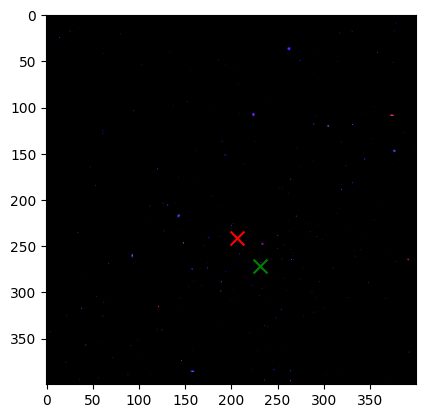

In [17]:
visual(input, output, nn_output.detach().numpy())